# Controller Run and Analyze w/ Grouped Output


## Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

# Import all shared dependencies and setup
from shared import *

In [2]:
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.width = 2000
png_renderer.height = 1200

from models.system_model_v3.model.params.init import params
from experiments.system_model_v3.run import run_experiment
from experiments.system_model_v3.post_process import post_process_results
from models.constants import RAY 

## Simulation Configuration

In [3]:
# Number of timesteps(hours) to run
# Max timesteps is 24*30*12 = 1 year
SIMULATION_TIMESTEPS = 24 * 30 * 4
SIMULATION_TIMESTEPS = 400

# Number of runs. Each run uses a different simulated ETH dataset
MONTE_CARLO_RUNS = 1

In [4]:
# Set param values. These will override defaults
# For details on params, see REF
params_override = { 
    'debug': [False],
    'eth_trend': [1],# 0=no trend; >0=uptrend; <0=downtrend 
    'liquidity_demand_enabled': [False],
    'liquidity_demand_shock': [False],
    'liquidation_buffer': [2],
    'max_redemption_rate': [50], # used by SAFE owners
    'min_redemption_rate': [-50], # used by SAFE owners
    'kp': [5e-8],
    'ki': [0],
    #'alpha': [1.0 * RAY],
    'alpha': [0.999999 * RAY],
    'trader_market_premium': [1.00],
    'rate_trader_count': [200],
    'rate_trader_mean_pct': [1.5],
    'rate_trader_min_pct': [1],
    'rate_trader_std_pct': [2 * (1.5-1)],
    'uniswap_fee': [0.003],
    'rate_trader_mean_days': [1],
    'rate_trader_min_days': [0],
    'rate_trader_std_days': [1 * (30-0)],
    'eth_leverager_target_min_liquidity_ratio': [2.7],
    'eth_leverager_target_max_liquidity_ratio': [2.7]
}
params.update(params_override)

## Run Simulation

In [5]:
start = time.time()
df_raw = run_experiment(timesteps=SIMULATION_TIMESTEPS,
               runs=MONTE_CARLO_RUNS, params=params);

print(f"Run experiment took {time.time() - start} secs")

Run experiment took 30.2050199508667 secs


In [6]:
df = post_process_results(df_raw, params, set_params=['kp', 'ki', 'rate_trader_std_days'])

In [7]:
# Optionally, trim results by timestep
df_trim = df[df['timestep'] >= 7*24][df['timestep'] <= 24*30*24]

In [8]:
def group_plot(df, run):
    """
    Show many plots from a single simulation run
    """
    
    fig = make_subplots(rows=5, cols=3, start_cell="top-left", vertical_spacing=0.06, 
                        horizontal_spacing=0.06,
                        subplot_titles=["ETH/USD","Kp rate(blue), Ki rate(red)", "Redemption Rate", 
                                        "RAI/USD", "Error",  "Rate Trader balances, RAI(purple), USD(green)",
                                        "Rate APY", "Error Integral", "ETH Leverager Collateral",
                                        "Total Debt", "Total Collateral", "Total C-Ratio",
                                        "RAI/ETH"])
   
    eth_usd = px.line(
            df.query(f'run == {run}'),
            title=f"ETH/USD",
            x="timestamp",
            color="run",
            color_discrete_sequence=["blue"],
            labels={"run": ""},
            y=["eth_price"]
        )
    eth_usd.data[0].name = "ETH/USD"
    eth_usd.update_layout(title_x=0.5)
    
    rai_eth = px.line(
            df.query(f'run == {run}'),
            title=f"RAI/ETH",
            x="timestamp",
            color="run",
            color_discrete_sequence=["green"],
            labels={"run": ""},
            y=["rai_eth"]
        )
    rai_eth.data[0].name = "RAI/ETH"
    rai_eth.update_layout(title_x=0.5)

    rai_usd = px.line(
            df.query(f'run == {run}'),
            title=f"RAI/USD",
            x="timestamp",
            color_discrete_sequence=["purple", "black"],
            y=["market_price_twap", "target_price"]
        )
    rai_usd.data[0].name = "RAI/USD TWAP"
    rai_usd.data[1].name = "Redemption Price"

    rai_apy = px.line(
            df.query(f'run == {run}'),
            title=f"Redemption Rate APY",
            x="timestamp",
            color_discrete_sequence=["blue"],
            y=["apy"]
        )
    rai_apy.data[0].name = "Redemption Rate(APY)"

    leverager_collateral = px.line(
            df.query(f'run == {run}'),#.query(f'khow == 7e-14'),
            title=f"ETH Leverager Collateral",
            x="timestamp",
            color_discrete_sequence=['red'],
            y=['eth_leverager_collateral']
        )
    leverager_collateral.data[0].name = "ETH Leverager Collateral"
    leverager_collateral.update_layout(title_x=0.5)

    leverager_collateral_diff = px.line(
            df.query(f'run == {run}'),#.query(f'khow == 7e-14'),
            title=f"ETH Leverager Collateral Diff",
            x="timestamp",
            color_discrete_sequence=['red'],
            y=['eth_leverager_collateral_diff']
        )
    leverager_collateral_diff.data[0].name = "ETH Leverager Collateral Diff"
    leverager_collateral_diff.update_layout(title_x=0.5)

    rate_trader = px.line(
            df.query(f'run == {run}'),#.query(f'khow == 7e-14'),
            title=f"Rate Trader balances",
            x="timestamp",
            color_discrete_sequence=['green', 'purple'],
            y=['rate_trader_base', 'rate_trader_total_rai_base']
        )
    rate_trader.data[0].name = "Rate Trader Base only"
    rate_trader.data[1].name = "Rate Trader RAI(Base)"
    rate_trader.update_layout(title_x=0.5)

    rate_comps = px.line(
            df.query(f'run == {run}'),
            title=f"Errors",
            x="timestamp",
            color_discrete_sequence=["blue", "red"],
            y=["kp_rate", "ki_rate"]
        )
    rate_comps.data[0].name = "Kp rate"
    rate_comps.data[1].name = "Ki rate"
    
    ki_rate = px.line(
            df.query(f'run == {run}'),
            title=f"Errors",
            x="timestamp",
            color_discrete_sequence=["red"],
            y=["ki_rate"]
        )
    ki_rate.data[0].name = "Ki rate"

    error = px.line(
            df.query(f'run == {run}'),
            title=f"Errors",
            x="timestamp",
            color_discrete_sequence=["blue"],
            y=["error_star"]
        )
    error.data[0].name = "Error"

    error_integral = px.line(
            df.query(f'run == {run}'),
            title=f"Errors",
            x="timestamp",
            color_discrete_sequence=["red"],
            y=["error_star_integral"]
        )
    error_integral.data[0].name = "Error Integral"
       
    target_rate = px.line(
            df.query(f'run == {run}'),
            title=f"RR",
            x="timestamp",
            color_discrete_sequence=["black"],
            y=["target_rate"]
    )
    
    target_rate.data[0].name = "Redemption Rate"

    eth_leverager_cratio = px.line(
            df.query(f'run == {run}'),
            title=f"ETH Leverager C-ratio",
            x="timestamp",
            color_discrete_sequence=['blue'],
            y=['eth_leverager_cratio']
        )
    eth_leverager_cratio.data[0].name = "ETH Leverager C-ratio"
    eth_leverager_cratio.update_layout(title_x=0.5)
    
    
    total_debt = px.line(
        df_trim.query(f'run == {run}'), 
        title="Total Debt",
        x="timestamp", 
        y=["principal_debt"], 
        color_discrete_sequence=['purple']
    )
    total_collateral = px.line(
        df_trim.query(f'run == {run}'), 
        title="Total collateral",
        x="timestamp", 
        y=["eth_collateral"], 
        color_discrete_sequence=['red']
    )
    
    total_cratio = px.line(
        df_trim.query(f'run == {run}'), 
        title="Total C-ratio",
        x="timestamp", 
        y=["collateralization_ratio"], 
        color_discrete_sequence=['orange']
    )
    total_cratio.update_layout(font={'size': 40})
    
    fig.update_layout(title_x=0.5)

    # First column
    fig.add_trace(eth_usd.data[0], row=1, col=1)
    fig.add_trace(rai_usd.data[0], row=2, col=1)
    fig.add_trace(rai_usd.data[1], row=2, col=1)
    fig.add_trace(rai_apy.data[0], row=3, col=1)
    fig.add_trace(total_debt.data[0], row=4, col=1)
    fig.add_trace(rai_eth.data[0], row=5, col=1)

    # Second column
    fig.add_trace(rate_comps.data[0], row=1, col=2)
    fig.add_trace(rate_comps.data[1], row=1, col=2)
    fig.add_trace(error.data[0], row=2, col=2)
    fig.add_trace(error_integral.data[0], row=3, col=2)
    fig.add_trace(total_collateral.data[0], row=4, col=2)
    
    # Third Column
    fig.add_trace(target_rate.data[0], row=1, col=3)
    fig.add_trace(rate_trader.data[0], row=2, col=3)
    fig.add_trace(rate_trader.data[1], row=2, col=3)
    fig.add_trace(leverager_collateral.data[0], row=3, col=3)
    fig.add_trace(total_cratio.data[0], row=4, col=3)

    fig.update_traces(line=dict(width=2))
    fig.update_layout(showlegend=False)

    # only show tick labels at bottom
    fig.update_xaxes(showticklabels=False) # hide all the xticks
    fig.update_xaxes(showticklabels=True, row=5, col=1)
    fig.update_xaxes(showticklabels=True, row=4, col=2)
    fig.update_xaxes(showticklabels=True, row=4, col=3)

    fig.update_annotations(font_size=24)
    fig.update_xaxes(
       tickfont = dict(size=18))

    fig.show()

run=1


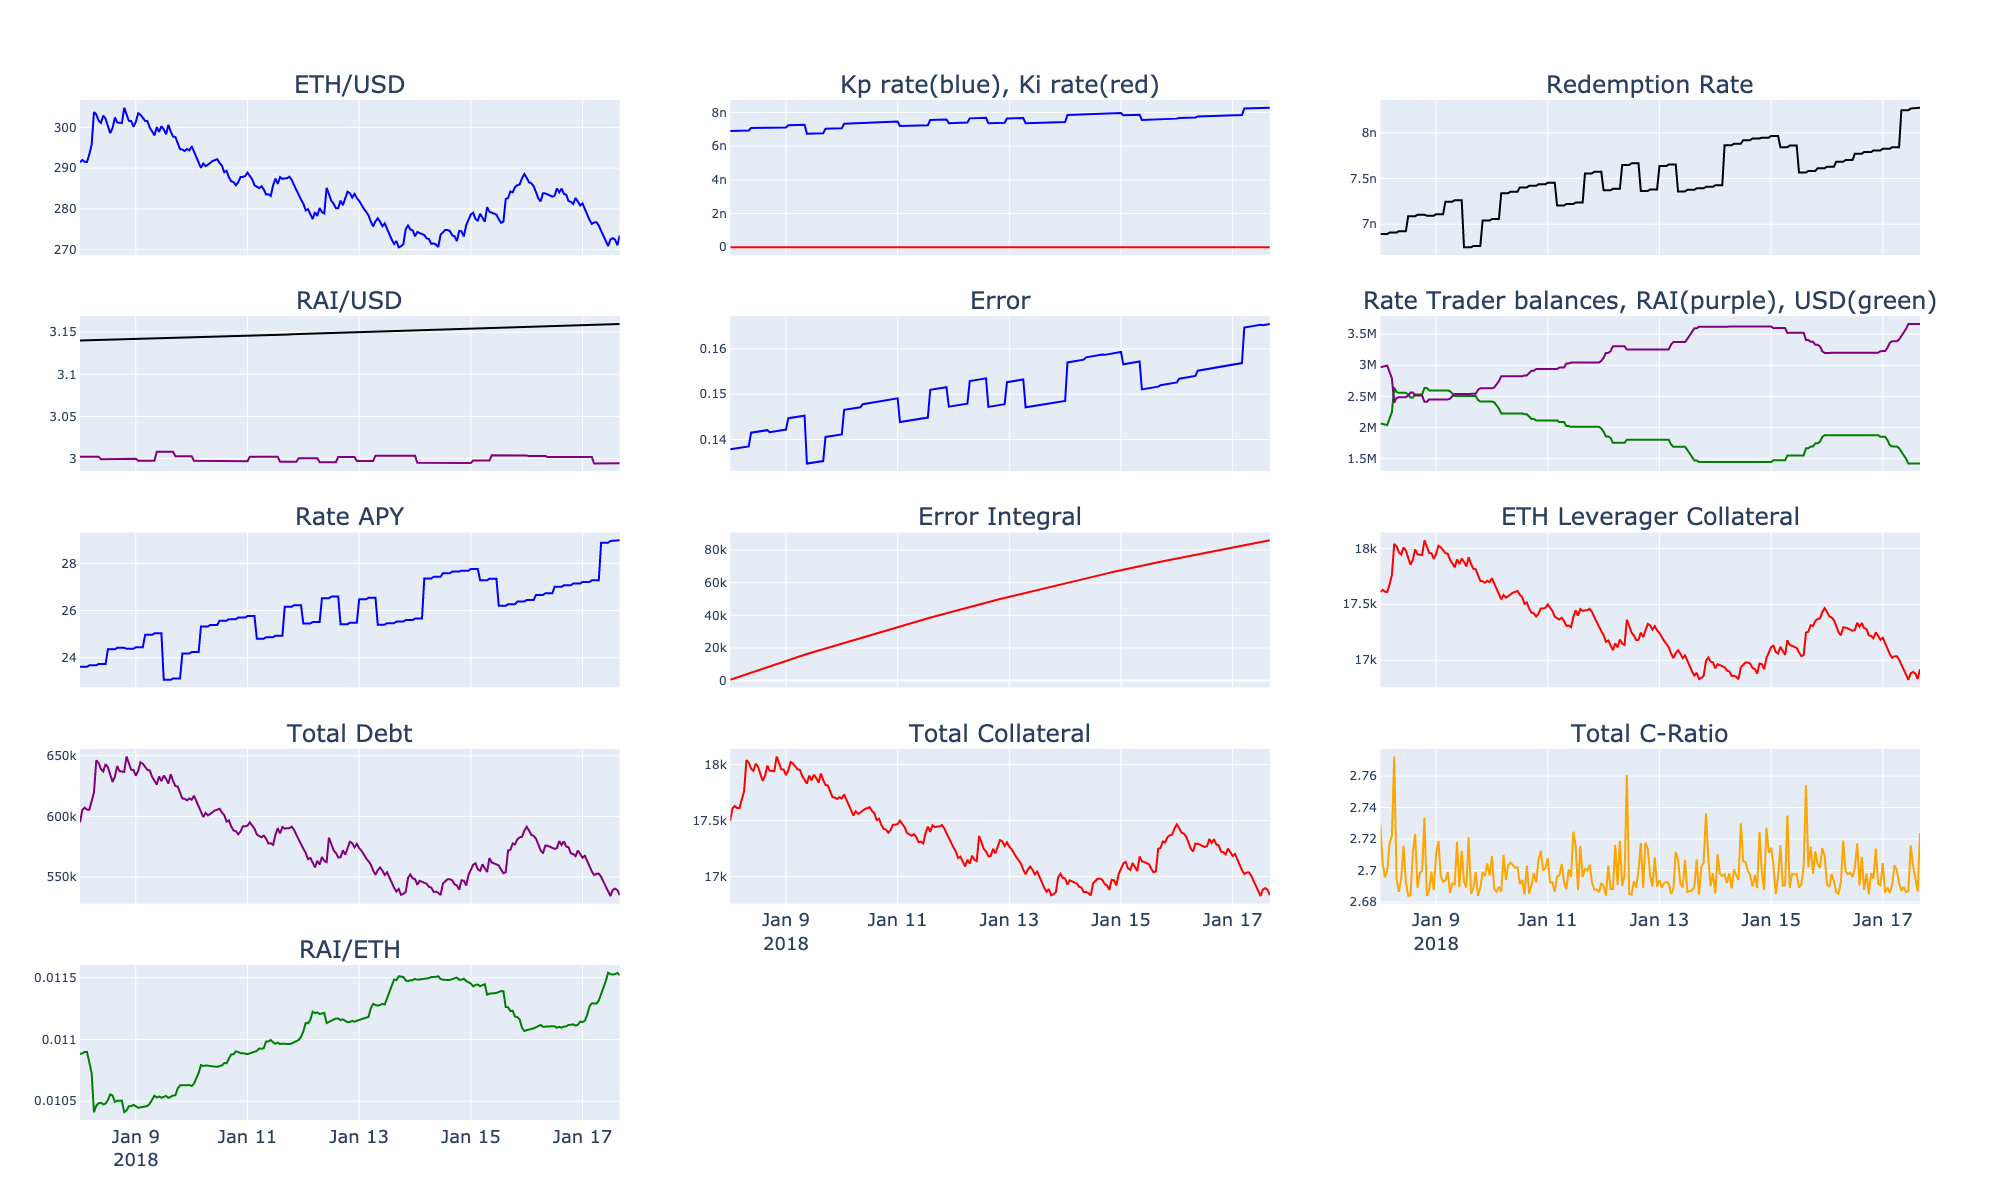

In [9]:
for run in range(1, MONTE_CARLO_RUNS + 1):
    print(f"{run=}")
    group_plot(df_trim, run)
    #group_plot(df_trim[df_trim['rate_trader_std_days'] != 1], run)

In [10]:
df_trim.columns

Index(['cdp_metrics', 'optimal_values', 'sim_metrics', 'timedelta',
       'cumulative_time', 'timestamp', 'blockheight', 'eth_price',
       'liquidity_demand', 'liquidity_demand_mean', 'cdps', 'eth_collateral',
       'eth_locked', 'eth_freed', 'eth_bitten', 'liquidity_cdp_eth_collateral',
       'liquidity_cdp_rai_balance', 'liquidity_cdp_count',
       'arbitrage_cdp_eth_collateral', 'principal_debt', 'rai_drawn',
       'rai_wiped', 'rai_bitten', 'accrued_interest', 'interest_dripped',
       'interest_wiped', 'interest_bitten', 'w_1', 'w_2', 'w_3',
       'system_revenue', 'stability_fee', 'market_price', 'market_price_twap',
       'target_price', 'target_rate', 'eth_return', 'eth_gross_return',
       'expected_market_price', 'expected_debt_price',
       'price_trader_rai_balance', 'price_trader_base_balance',
       'price_traders', 'rate_trader_rai_balance', 'rate_trader_base_balance',
       'rate_traders', 'error_star', 'prev_error_star', 'error_star_integral',
       'cur

In [11]:
df_trim['subset'].unique()

array([0])

In [12]:
df_trim['market_price'].mean(), df_trim['market_price'].std()

(3.0023022577506846, 0.00774552472508973)

In [13]:
df_trim['market_price_twap'].mean(), df_trim['market_price_twap'].std()

(2.9996206845650164, 0.003585063402401506)

In [14]:
df_trim['error_star'].mean(), df_trim['error_star'].std() # error = target_price - market_twap

(0.1499884736861578, 0.007063057970254822)

In [15]:
(df_trim['target_price'] - df_trim['market_price_twap']).mean()

0.15007337363238088

In [16]:
(df_trim['target_price'] - df_trim['market_price']).mean()

0.14739180044671313

In [17]:
(df_trim['market_price_twap'] - df_trim['market_price']).mean()

-0.0026815731856677555

In [18]:
df_trim['target_price'].mean()

3.149694058197398

In [19]:
df_trim['target_rate'].mean()

7.48705181778248e-09

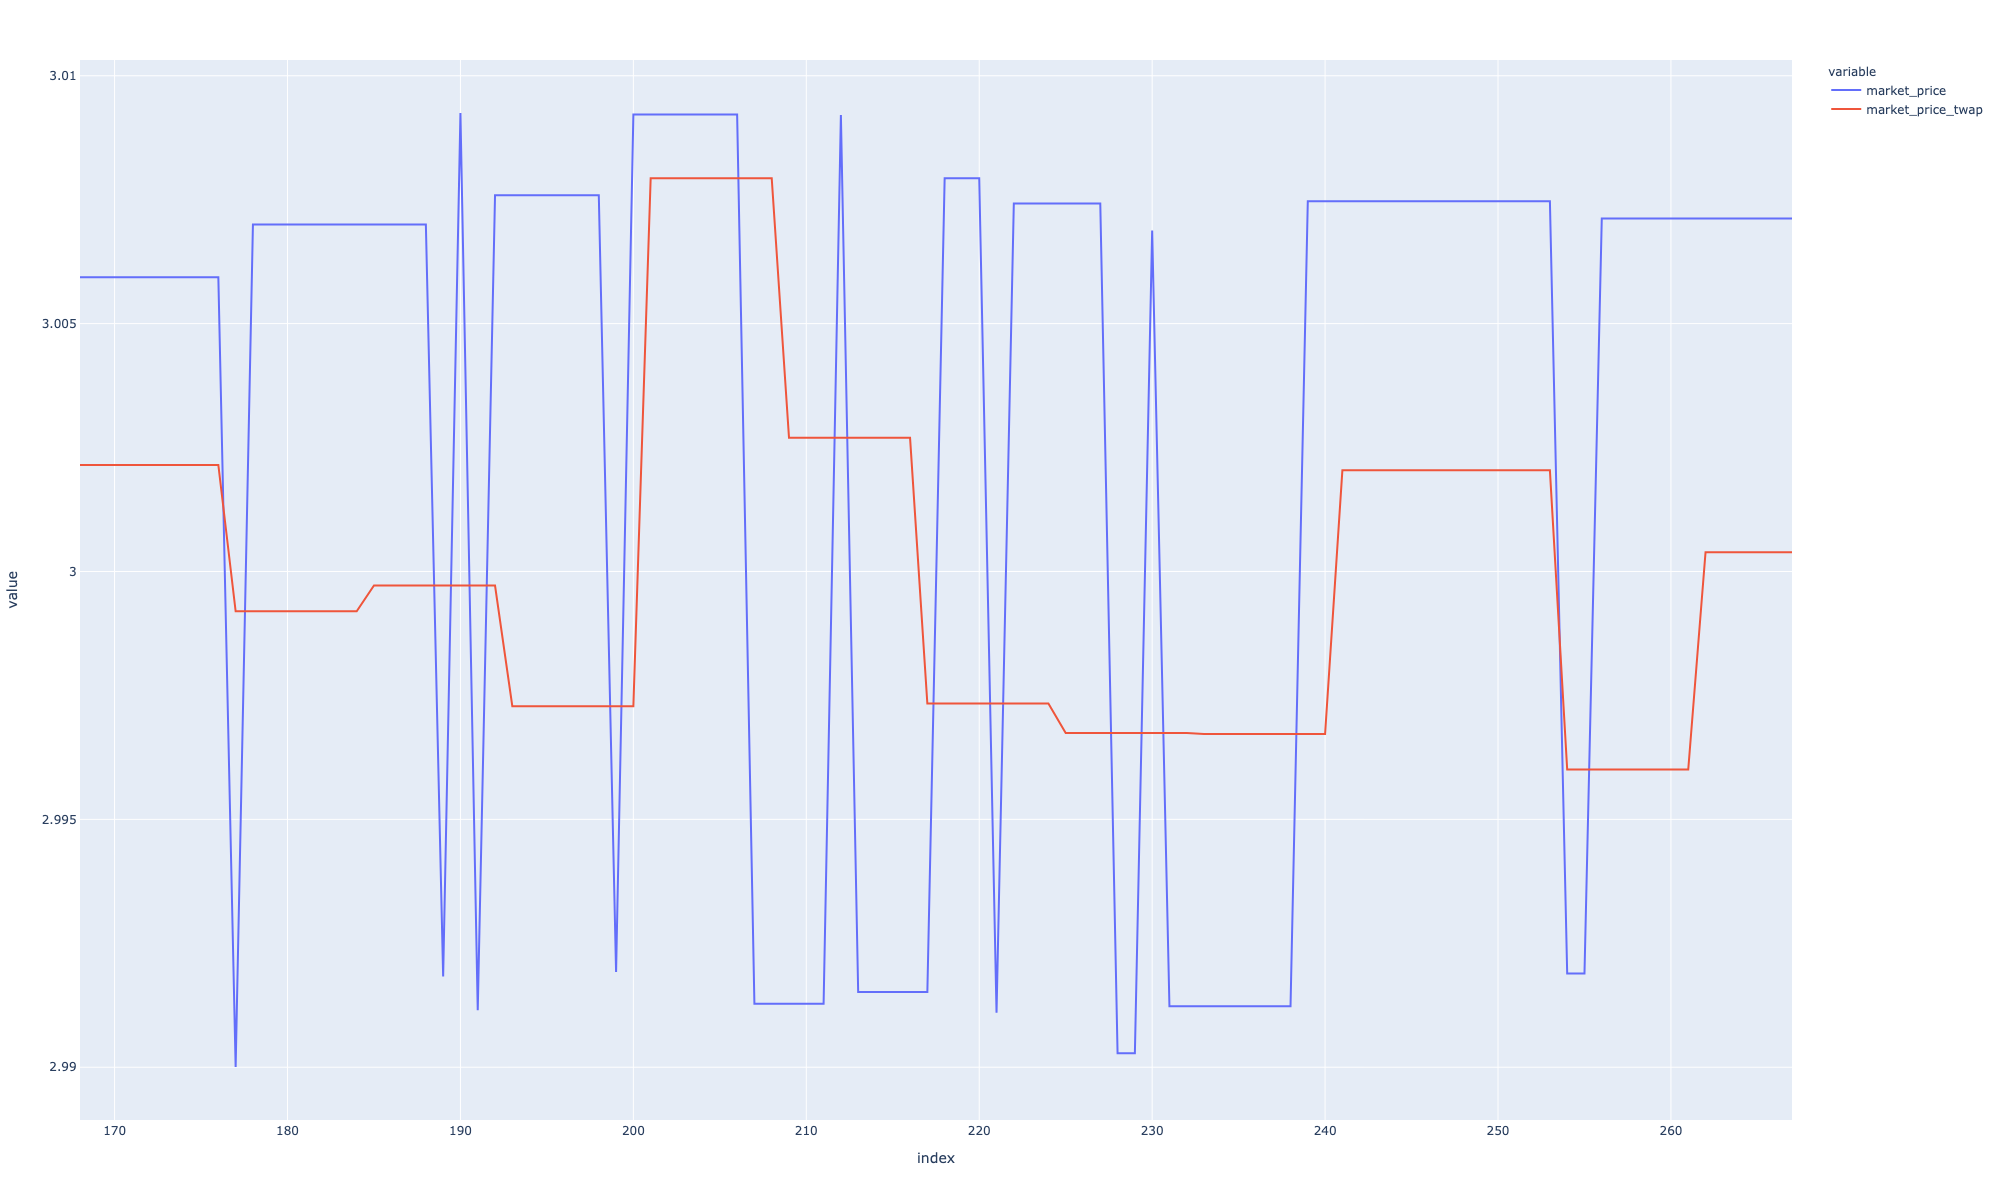

In [20]:
df_trim[['market_price', 'market_price_twap']][:100].plot()